# Thailand CO2 emission forecast using LSTM

The goal of this notebook is to analyse carbon dioxide emission in 1987-2022 in Thailand caused by transport using oil fuel and to make a forecast the value of emission in every month in 2023.<br>
The dataset is taken from https://www.kaggle.com/datasets/thaweewatboy/thailand-carbon-emission-statistics?resource=download <br>
We're going to implement a forecast for 2023 using recurrent neural network.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from tqdm.auto import tqdm

In [19]:
df = pd.read_csv('thailand_co2_emission_1987_2022.csv')
df = df[(df['source'] == 'transport') & (df['fuel_type'] == 'oil')]
df['period'] = pd.to_datetime({'year': df['year'], 'month': df['month'], 'day': 1})
df = df[['period', 'emissions_tons']]
df.head()

,period,emissions_tons
0,1987-01-01,1588.61
1,1987-02-01,1428.29
2,1987-03-01,1581.16
3,1987-04-01,1557.40
4,1987-05-01,1513.35


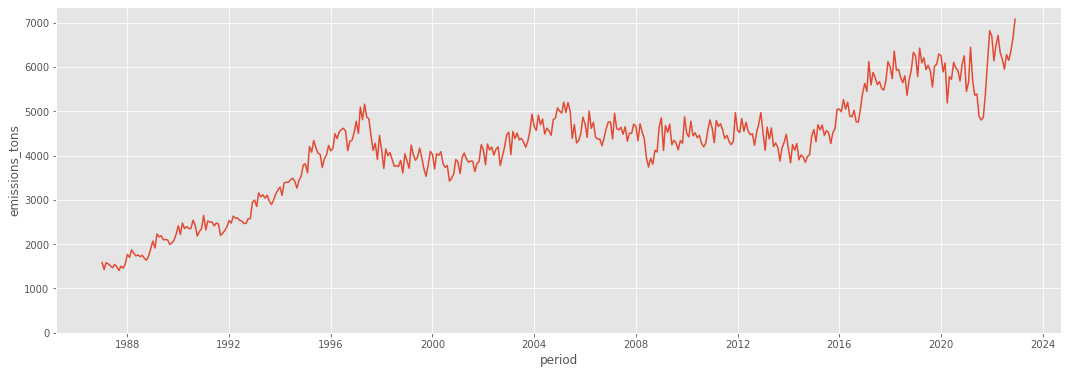

In [20]:
plt.style.use('ggplot')
plt.figure(figsize=(18, 6))
sns.lineplot(data=df, x='period', y='emissions_tons')
plt.ylim(0)
plt.show()

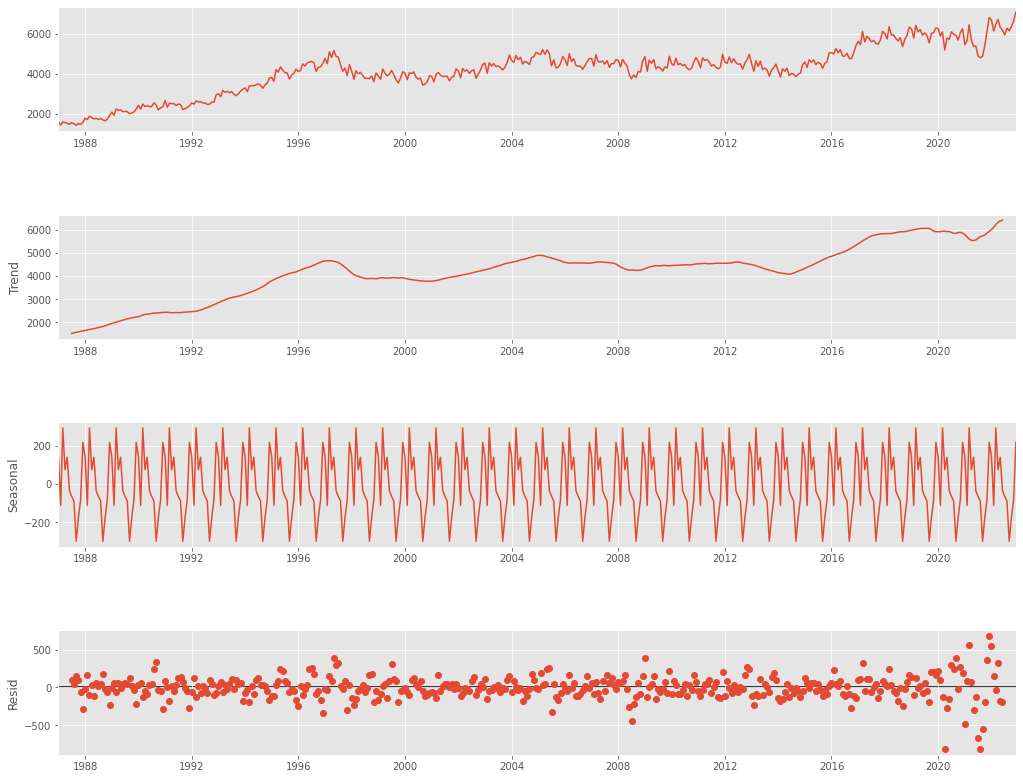

In [21]:
figure = seasonal_decompose(df.set_index('period')).plot()
figure.set_size_inches(16, 12)

In [22]:
# train-test split for time series

test_periods = 36

train = df['emissions_tons'][:-test_periods].to_numpy()
test = df['emissions_tons'][-test_periods:].to_numpy()

len(train), len(test)

(396, 36)

In [23]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
train_scaled = torch.FloatTensor(train_scaled).view(-1)
train_scaled[:5]

tensor([-2.1982, -2.3431, -2.2050, -2.2264, -2.2662])

Now we should choose the train window size. As we have yearly data it makes sense to use size multiples of 12, let's take 24. Then we'll be able to create data sequences for training.

In [24]:
train_window = 24

In [25]:
def create_inout_sequences(input_data, train_window):
    inout_seq = []
    for i in range(len(input_data) - train_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window:i+train_window+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_scaled, train_window)

Now let's define our neural network, loss function, optimizer and start training.

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)       
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_layer_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        output = self.relu(lstm_out.view(len(input_seq), -1))
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        predictions = self.fc3(output)
        return predictions[-1]

In [27]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [28]:
num_epochs = 500
losses = []

model.train()
for epoch in tqdm(range(1, num_epochs + 1)):
    epoch_losses = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        epoch_losses.append(loss.detach().cpu().numpy())
        optimizer.step()
    losses.append(sum(epoch_losses) / len(epoch_losses))  
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}. Loss: {sum(epoch_losses) / len(epoch_losses):.6f}')


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50. Loss: 0.028042
Epoch 100. Loss: 0.014160
Epoch 150. Loss: 0.012831
Epoch 200. Loss: 0.009543
Epoch 250. Loss: 0.006328
Epoch 300. Loss: 0.005535
Epoch 350. Loss: 0.007698
Epoch 400. Loss: 0.003241
Epoch 450. Loss: 0.003648
Epoch 500. Loss: 0.003696


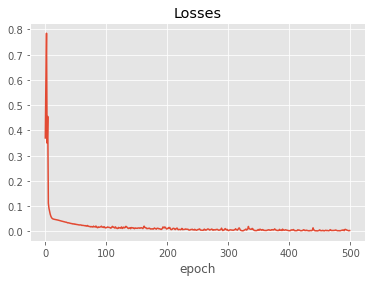

In [29]:
plt.plot(losses)
plt.xlabel('epoch')
plt.title("Losses")
plt.show()

In [30]:
fut_pred = 36

test_inputs = train_scaled[-train_window:].tolist()

model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [31]:
y_pred = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1)).flatten()

In [32]:
MAPE(test, y_pred)

0.07785570214435367

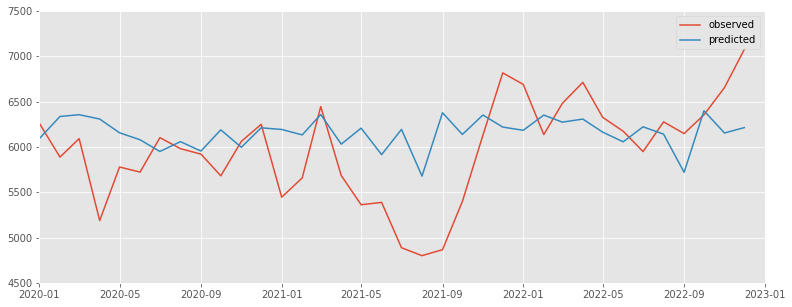

In [33]:
plt.figure(figsize=(13, 5))
plt.plot(df['period'], df['emissions_tons'])
plt.plot(df['period'].iloc[-36:], y_pred)
plt.legend(['observed', 'predicted'])
plt.xlim(['2020-01-01', '2023-01-01'])
plt.ylim([4500, 7500])
plt.show()

Our neural network performs quite well with MAPE less than 8%. But we can see serious deviations from observed data in spring of 2020 and in the middle of 2021. That can be explained by pandemic restrictions which made a great impact on country's economy. This time series pattern couldn't be predicted by our model.

In [34]:
result = pd.DataFrame({'period': df['period'].iloc[-36:],
                       'observed': df['emissions_tons'].iloc[-36:],
                       'predicted': y_pred})
result['difference'] = result['predicted'] - result['observed']
result['difference, %'] = np.abs(result['difference'] / result['observed']) * 100
result.round(2)

,period,observed,predicted,difference,"difference, %"
396,2020-01-01,6259.42,6092.46,-166.96,2.67
397,2020-02-01,5887.56,6335.67,448.11,7.61
398,2020-03-01,6091.05,6355.42,264.37,4.34
399,2020-04-01,5186.49,6307.52,1121.03,21.61
400,2020-05-01,5777.98,6155.80,377.82,6.54
401,2020-06-01,5722.02,6078.79,356.77,6.24
402,2020-07-01,6102.24,5949.43,-152.81,2.50
403,2020-08-01,5980.50,6058.02,77.52,1.30
404,2020-09-01,5920.29,5954.53,34.24,0.58
405,2020-10-01,5680.79,6188.21,507.42,8.93
